In [1]:
# env init
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import joblib
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [2]:
# origin part
env="origin"

# path init
# check env dir if exist in working path
if not os.path.exists("./"+env):
    os.makedirs("./"+env)
working_path = "./"+env 
# check img dir if exist in working path
if not os.path.exists(working_path+"/img"):
    os.makedirs(working_path+"/img")
# read df csv
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

categories = [
    d
    for d in os.listdir("./Aerial_Landscapes")
    if os.path.isdir(os.path.join("./Aerial_Landscapes", d))
]  # because original dataset already split imgs into folders with specific names, so use it as label

In [3]:
# prepare the dataframe
# THIS IS ORIGIN DATASET, NO NEED TO SPLIT OR EDIT
# JUST DO IT

In [4]:
# SIFT for getting keypoints and descriptors

sift = cv2.SIFT_create()
# save sift descriptors and keypoints
sift_descriptors_list = []

# start sift, only on train df
for index, row in train_df.iterrows():
    image_path = row["image_path"]
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(
        gray_image, None
    )  # sift can produce kpt and des, but only des for KNN train
    if descriptors is not None and descriptors.ndim == 2:
        sift_descriptors_list.append(descriptors)

# show number of keypoints and descriptors
print("###ORIGINAL TRAIN DF###")
print(f"Number of  descriptors: {len(sift_descriptors_list)}")

# save sift descriptors
with open(working_path + "/sift_origin_descriptors_list.pkl", "wb") as f:
    pickle.dump(sift_descriptors_list, f)
# estimate time cost: 2m 49s(last time)
# 3m4.9s 8:2 split

###ORIGINAL TRAIN DF###
Number of  descriptors: 9532


In [5]:
# build boW

# flatten the list of descriptors and fit kmeans
if sift_descriptors_list:
    all_descriptors = np.vstack(sift_descriptors_list)

# define KNN config
k = 300  # number of clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
kmeans.fit(all_descriptors)

def get_bow_histogram(descriptors, kmeans):
    if descriptors is not None:
        # predict the cluster for each descriptor
        cluster_indices = kmeans.predict(descriptors)
        # count the occurrences of each cluster index
        histogram, _ = np.histogram(cluster_indices, bins=np.arange(k + 1), density=True)
        return histogram
    else:
        # if descriptors is None, return a zero histogram
        return np.zeros(k)
    
def get_bow_features(dataframe,image_path, kmeans):
    x_temp= []
    y_temp= []

    for index, row in dataframe.iterrows():
        image_path = row['image_path']
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, descriptors = sift.detectAndCompute(gray_image, None)

        # get the histogram for the image
        histogram = get_bow_histogram(descriptors, kmeans)

        x_temp.append(histogram)
        y_temp.append(row['label'])
    return np.array(x_temp), np.array(y_temp)

x_train = []
y_train = []

for index, row in train_df.iterrows():
    image_path = row['image_path']
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # get the histogram for the image
    histogram = get_bow_histogram(descriptors, kmeans)

    x_train.append(histogram)
    y_train.append(row['label'])

# convert to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = get_bow_features(test_df, image_path, kmeans)

# save to disk
np.save(working_path + '/x_train.npy', x_train)
np.save(working_path + '/y_train.npy', y_train)
np.save(working_path + '/x_test.npy', x_test)
np.save(working_path + '/y_test.npy', y_test)

# estimate time cost: 5min 0.2s(last time)

d:\Dev\anaconda3\envs\SIFT_KNN\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [6]:
# start training, by KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# test the model on test set
y_pred = knn.predict(x_test)

# try on validation set
#y_val_pred = knn.predict(x_val)

# save knn model
joblib.dump(knn, working_path + '/knn_model.pkl')
np.save(working_path + '/y_pred.npy', y_pred)
np.save(working_path + '/y_test.npy', y_test)

Accuracy: 0.51
              precision    recall  f1-score   support

 Agriculture       0.55      0.41      0.47       160
     Airport       0.36      0.48      0.41       160
       Beach       0.61      0.19      0.29       160
        City       0.34      0.88      0.49       160
      Desert       0.59      0.34      0.43       160
      Forest       0.66      0.86      0.75       160
   Grassland       0.61      0.42      0.50       160
     Highway       0.47      0.44      0.45       160
        Lake       0.36      0.26      0.30       160
    Mountain       0.53      0.76      0.63       160
     Parking       0.89      0.74      0.81       160
        Port       0.89      0.31      0.46       160
     Railway       0.46      0.77      0.57       160
 Residential       0.64      0.68      0.65       160
       River       0.41      0.19      0.26       160

    accuracy                           0.51      2400
   macro avg       0.56      0.51      0.50      2400
weighted av

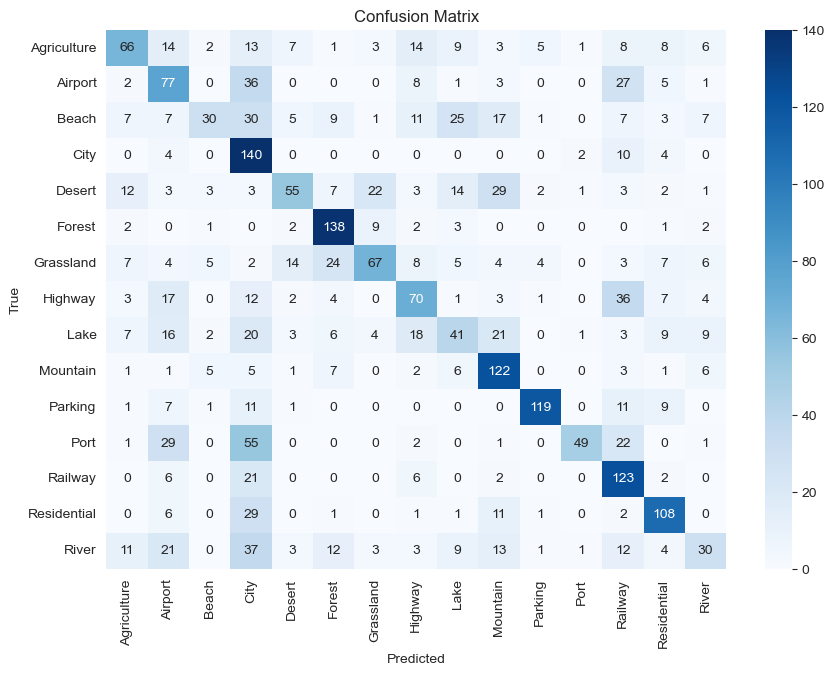

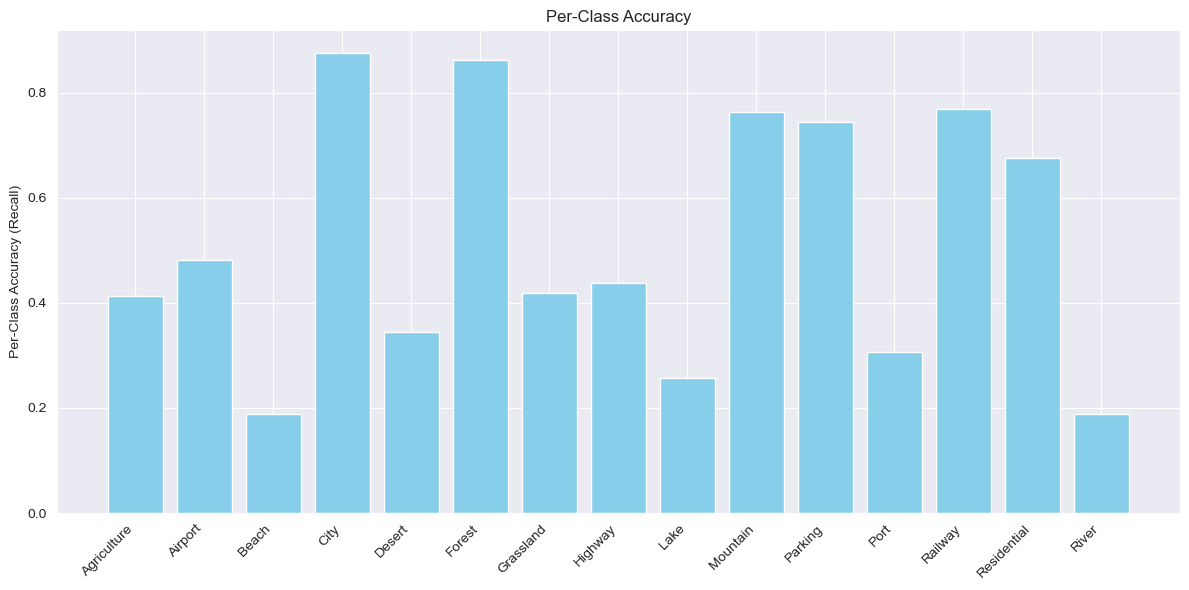

In [8]:
# show results by plt


# show accuracy
accuracy = accuracy_score(y_test, y_pred)  
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=categories))

# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# show accuracy by each cateq,using bar chart via plt
# x axis, y axis accuracy
per_class_acc = np.diag(cm) / cm.sum(axis=1)
plt.figure(figsize=(12,6))
plt.bar(categories, per_class_acc, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Per-Class Accuracy (Recall)')
plt.title('Per-Class Accuracy')
plt.tight_layout()
plt.show()
